In [481]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

In [101]:
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

from sklearn.model_selection import (StratifiedGroupKFold,
    StratifiedShuffleSplit, cross_val_score, learning_curve, RepeatedStratifiedKFold, GridSearchCV, train_test_split, ShuffleSplit
)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb


from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, OrdinalEncoder)

from scipy.stats.mstats import winsorize

In [868]:

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [5]:
data['Died'] = 1 - data['Survived']

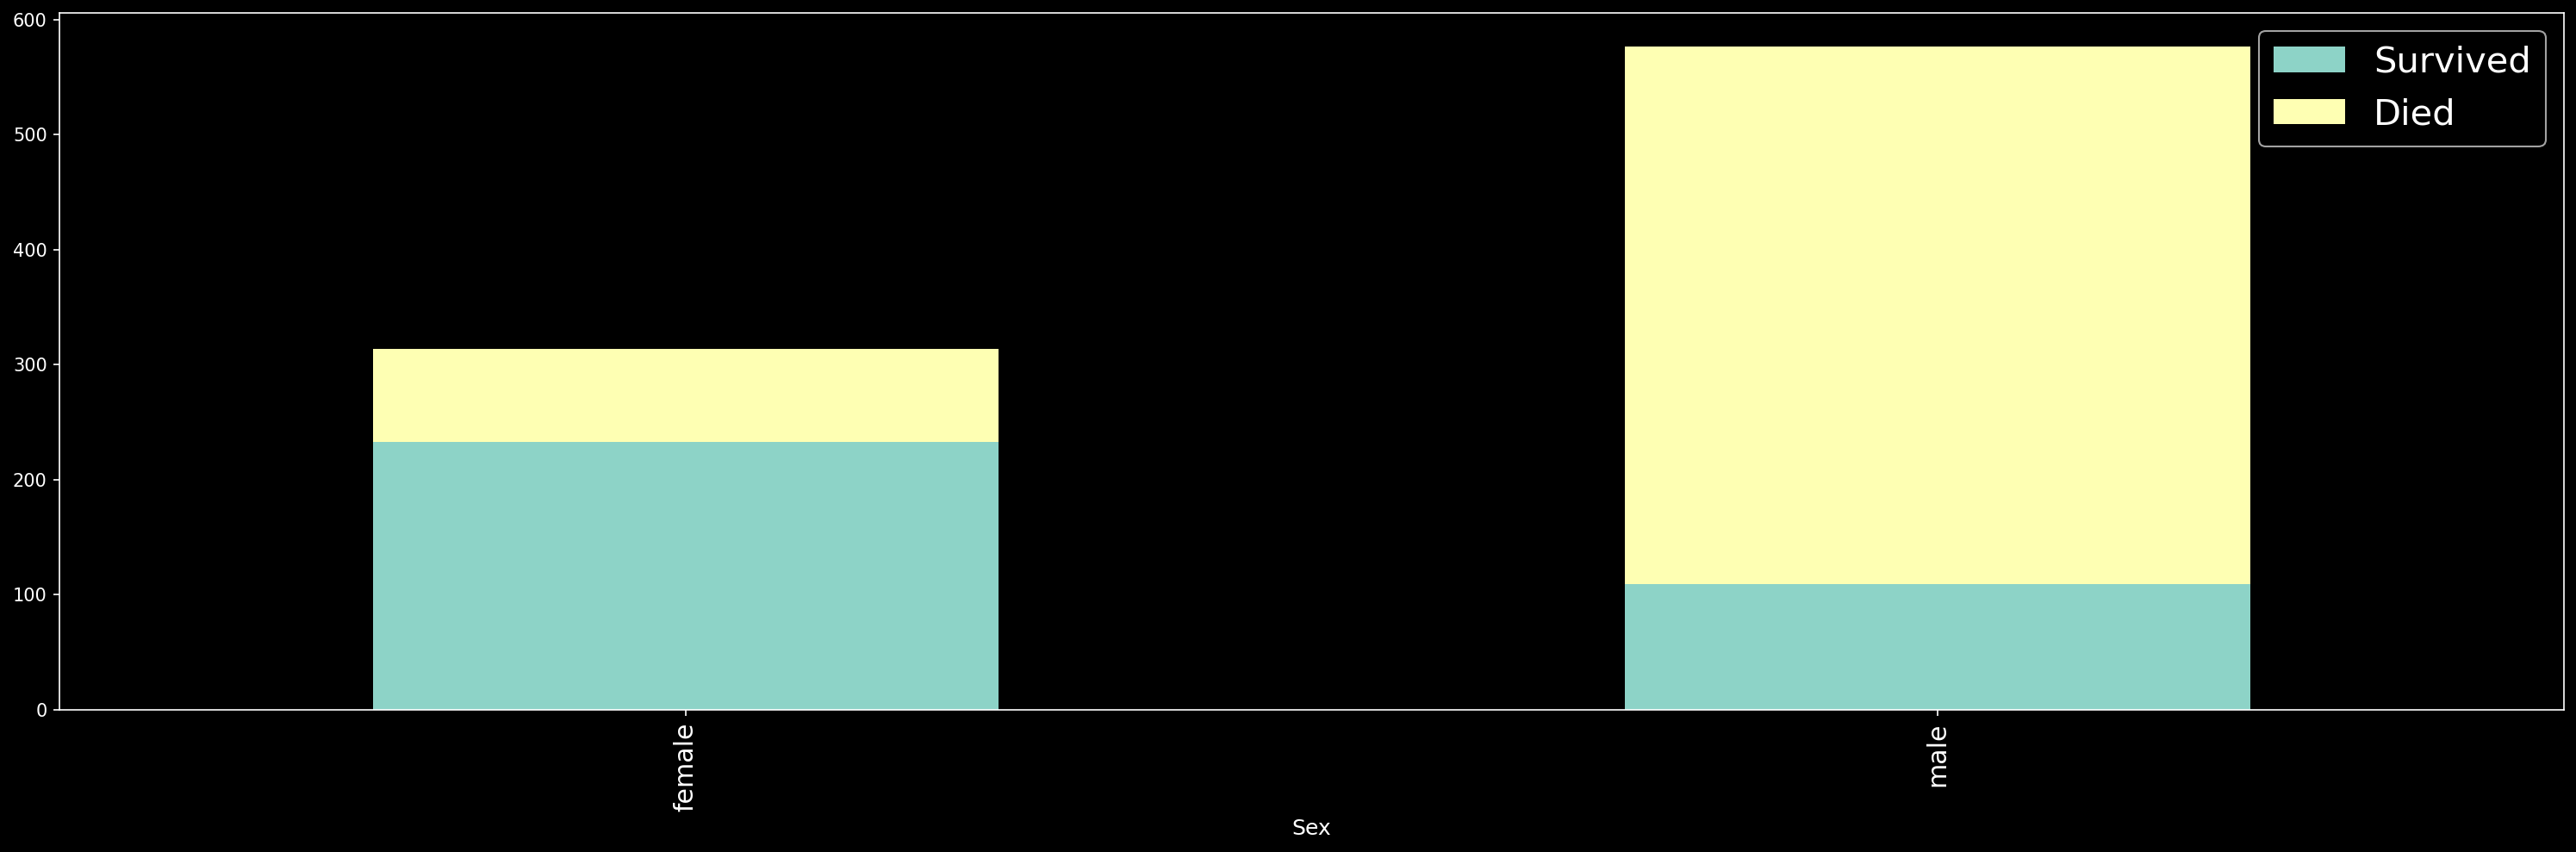

In [8]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

In [10]:
def status(feature):
    print ('Processing', feature, ': ok')

In [60]:
def get_combined_data():
    # reading train data
    train = pd.read_csv("train.csv")
    
    # reading test data
    test = pd.read_csv("test.csv")

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop(columns = ['Survived'], inplace=True)
    

    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined =  pd.concat([train, test], ignore_index=True)
    combined.drop(columns = ['PassengerId'], inplace=True)
    
    return combined

In [61]:
combined = get_combined_data()

In [28]:
combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [62]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [30]:
titles

{'Capt',
 'Col',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [63]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

In [64]:
combined = get_titles()

Processing Title : ok


In [33]:
combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Royalty
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr


In [34]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [65]:
combined['Age'] = pd.to_numeric(combined['Age'], errors='coerce')

In [66]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])['Age']
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [41]:
grouped_median_train.head(5)

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


In [67]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined

In [68]:
combined = process_age()

Processing age : ok


In [69]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

In [70]:
combined = process_names()

Processing names : ok


In [51]:
combined.head(5)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,True,False,False,False
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False,True,False,False
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,True,False,False,False,False
3,1,female,35.0,1,0,113803,53.1000,C123,S,False,False,False,True,False,False
4,3,male,35.0,0,0,373450,8.0500,NaN,S,False,False,True,False,False,False


In [71]:
def process_fares():
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined

combined = process_fares()

Processing fare : ok


In [72]:
def process_embarked():
    global combined
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined

combined = process_embarked()

Processing embarked : ok


In [73]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

In [55]:
train_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'}

In [56]:
test_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'U'}

In [74]:
def process_cabin():
    global combined    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

combined = process_cabin()

Processing cabin : ok


In [75]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

combined = process_sex()

Processing Sex : ok


In [76]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

combined = process_pclass()

Processing Pclass : ok


In [77]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [78]:
tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

In [ ]:
def process_ticket():
    global combined

    # функция для очистки префикса билета
    def cleanTicket(ticket):
        # удаляем точки и слэши
        ticket = ticket.replace(".", "").replace("/", "")
        # разбиваем по пробелам
        parts = ticket.split()
        # убираем пробелы по краям и оставляем только те части, которые не состоят полностью из цифр
        parts = [p.strip() for p in parts if not p.strip().isdigit()]
        # если после фильтрации что-то осталось — берём первый элемент, иначе 'XXX'
        return parts[0] if len(parts) > 0 else "XXX"

    # применяем к колонке Ticket, создаём новые dummy-фичи
    combined["Ticket"] = combined["Ticket"].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined["Ticket"], prefix="Ticket")
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop("Ticket", axis=1, inplace=True)
    status('Ticket')

    return combined

combined = process_ticket()

In [84]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

combined = process_family()

Processing family : ok


In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [87]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [88]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

In [89]:
train, test, targets = recover_train_test_target()

In [90]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

<Axes: ylabel='feature'>

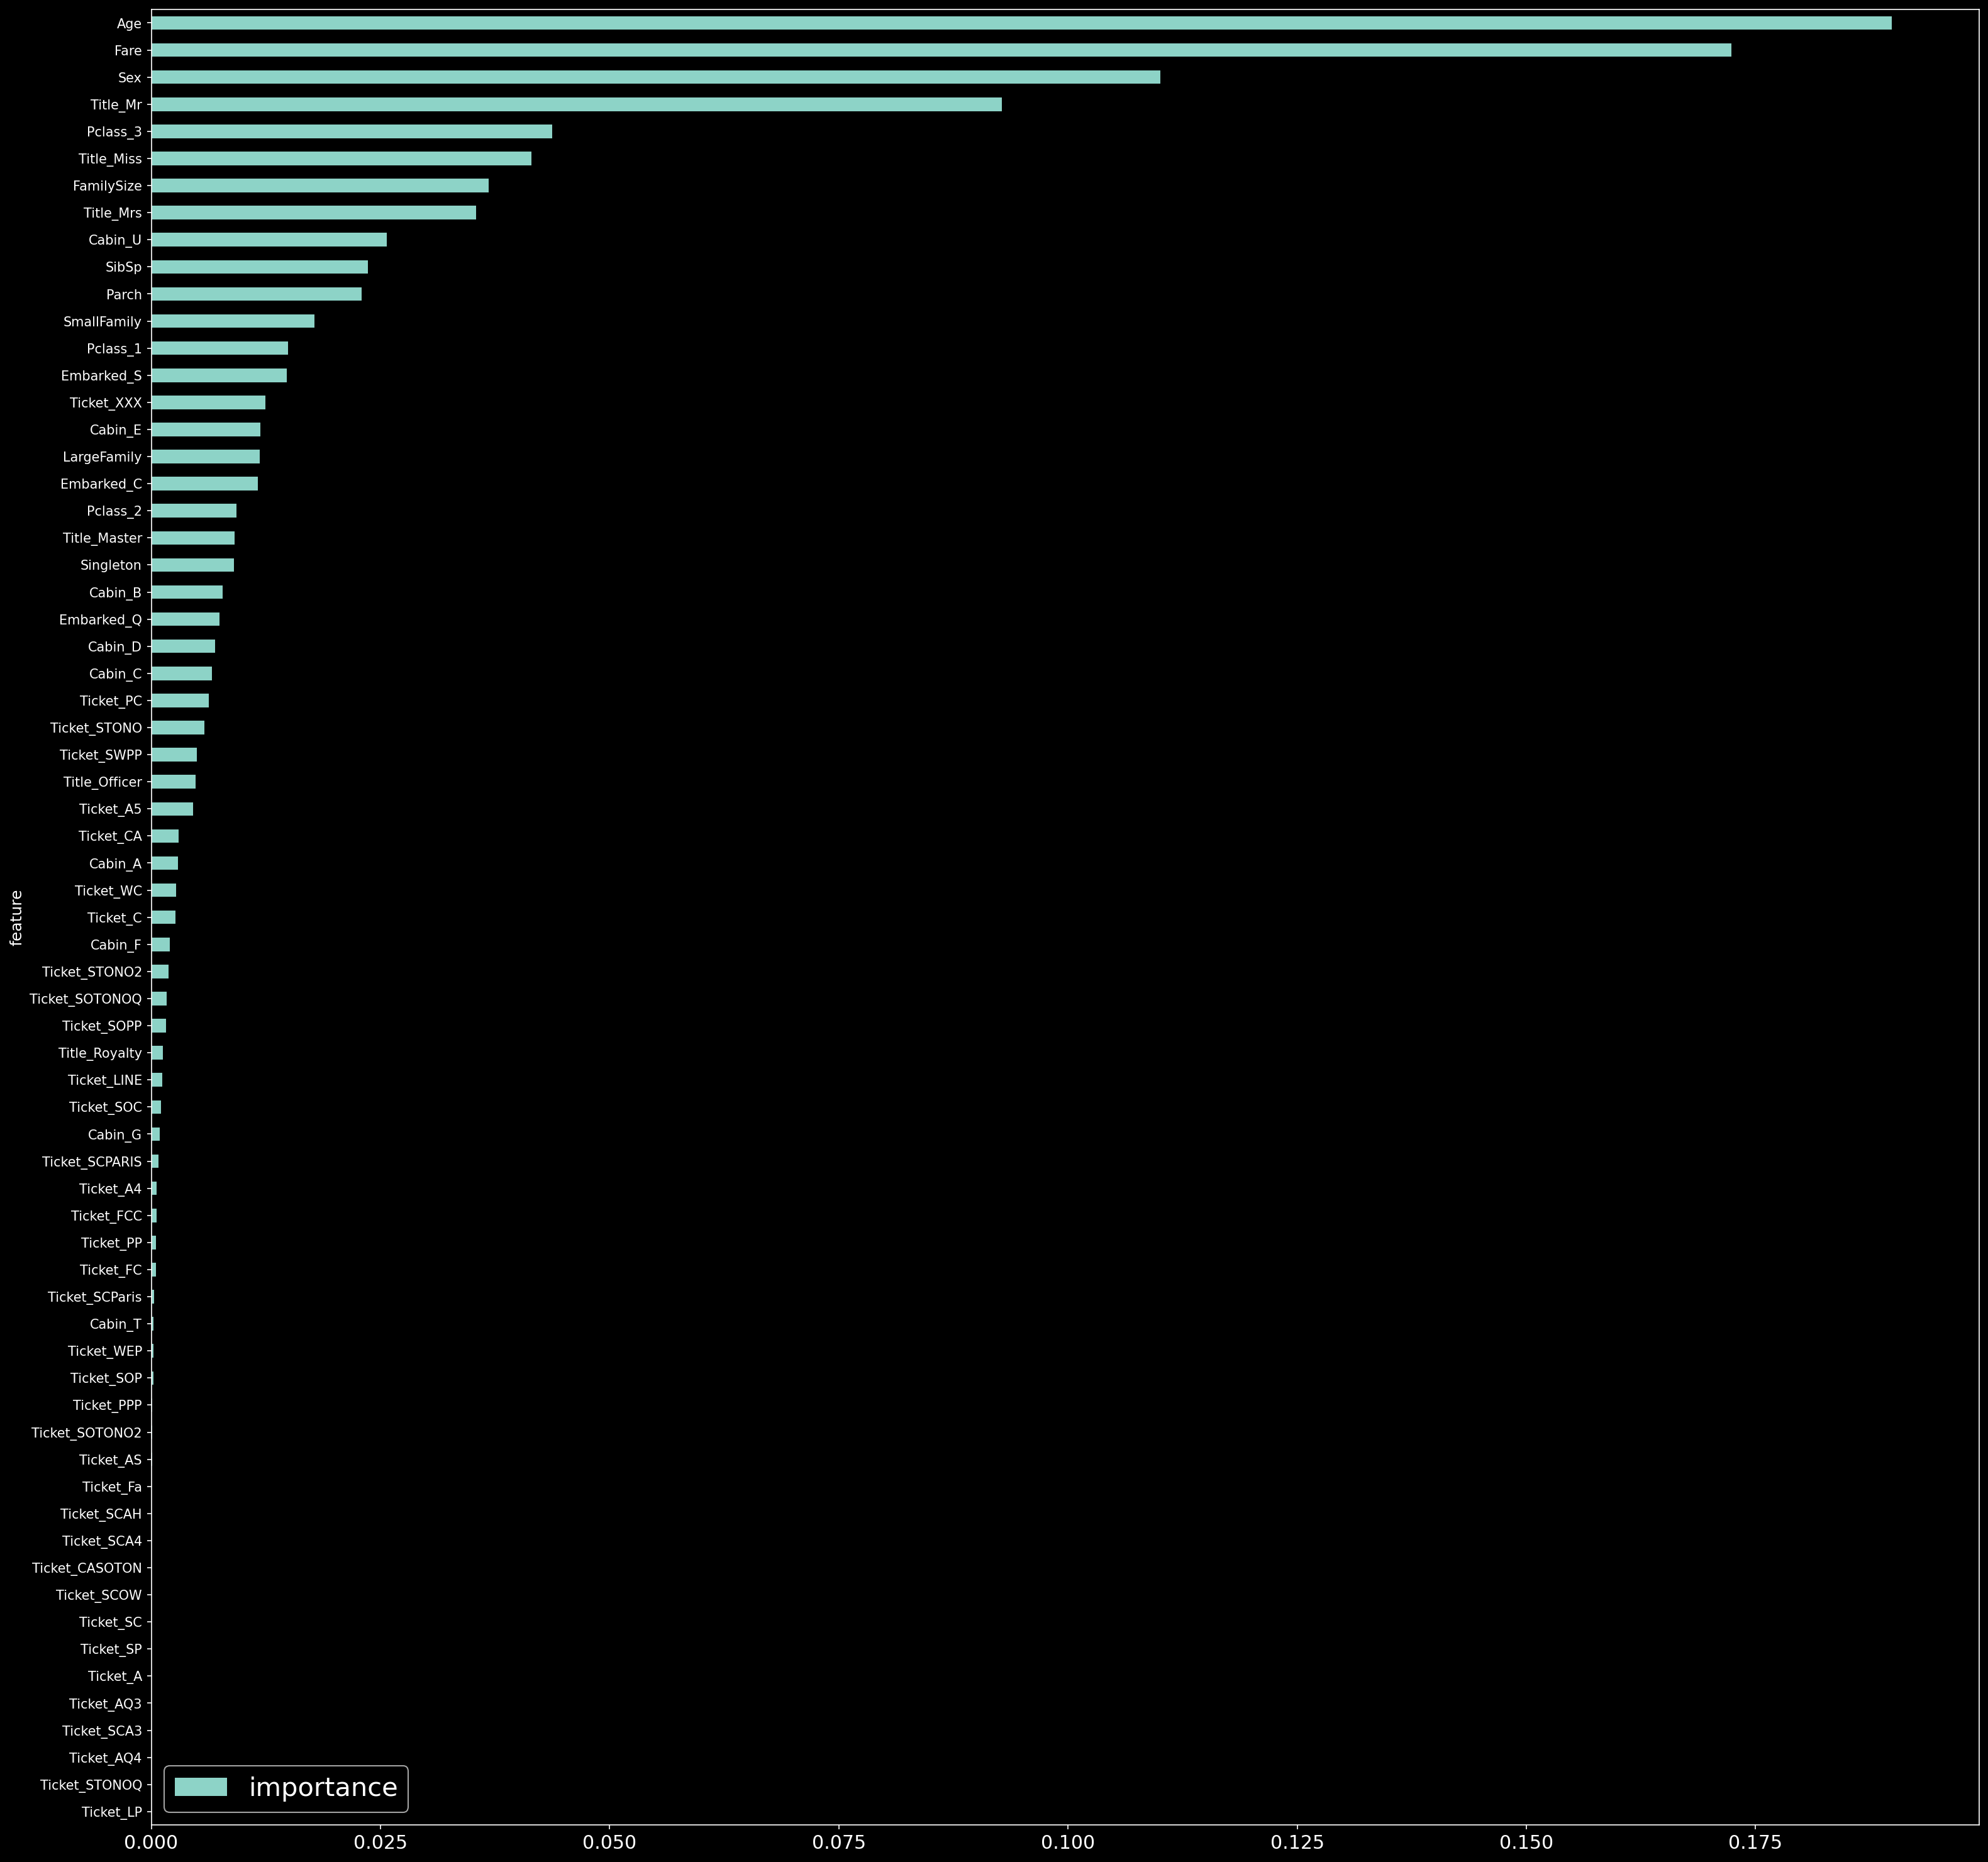

In [91]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

In [92]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)

In [93]:
test_reduced = model.transform(test)

In [94]:
train_reduced.shape, test_reduced.shape

((891, 12), (418, 12))

In [120]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()
catboost = CatBoostClassifier(silent=True)
xgboost = xgb.XGBClassifier()
lgboost = lgb.LGBMClassifier()
hgboost = HistGradientBoostingClassifier()
ada = AdaBoostClassifier()
mlp = MLPClassifier(max_iter=1000)


models = [logreg, logreg_cv, rf, gboost, catboost, xgboost, lgboost, hgboost, ada, mlp]

In [121]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print ('CV score = {0}'.format(score))

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8192894356914193
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.8215429037725188
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8125792480070302
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8282656455966355
Cross-validation of : <class 'catboost.core.CatBoostClassifier'>
CV score = 0.830500282468144
Cross-validation of : <class 'xgboost.sklearn.XGBClassifier'>
CV score = 0.8091833532107211
Cross-validation of : <class 'lightgbm.sklearn.LGBMClassifier'>
CV score = 0.8249262444291006
Cross-validation of : <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
CV score = 0.828278199736363
Cross-validation of : <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
CV score = 0.8036155922415416
Cross-va

In [138]:
import optuna
from sklearn.model_selection import GroupKFold
from catboost import CatBoostClassifier, Pool

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
import optuna

cv = ShuffleSplit(n_splits=10, test_size=0.35, random_state=42)

def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_loguniform("C", 1e-3, 10.0),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        'class_weight' : trial.suggest_categorical("class_weight", [None, "balanced"]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "intercept_scaling": trial.suggest_float("intercept_scaling", 1.0, 10.0),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter":  trial.suggest_int("iterations", 100, 1500, step=100),
        "random_state": 42,
    }

    fold_scores = []
    for tr_idx, val_idx in cv.split(train, targets):
        X_tr, X_val = train.iloc[tr_idx], train.iloc[val_idx]
        y_tr, y_val = targets[tr_idx], targets[val_idx]

        model = LogisticRegression(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        fold_scores.append(acc)

    return np.mean(fold_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, show_progress_bar=True)

print("Лучший CV-score:", round(study.best_value, 4))
print("Лучшие параметры:", study.best_params)

[I 2025-05-31 11:51:14,099] A new study created in memory with name: no-name-8bc4519d-7a3b-4f66-b6fc-b28b50eac4b7


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-05-31 11:51:14,225] Trial 0 finished with value: 0.6833333333333333 and parameters: {'penalty': 'l1', 'C': 0.003698317411918253, 'solver': 'saga', 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 1.6151386309890485, 'tol': 4.597378424775403e-05, 'iterations': 200}. Best is trial 0 with value: 0.6833333333333333.
[I 2025-05-31 11:51:14,262] Trial 1 finished with value: 0.6836538461538462 and parameters: {'penalty': 'l1', 'C': 0.002113942713136534, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 9.85279896885527, 'tol': 0.00845159644736021, 'iterations': 800}. Best is trial 1 with value: 0.6836538461538462.
[I 2025-05-31 11:51:14,291] Trial 2 finished with value: 0.792948717948718 and parameters: {'penalty': 'l1', 'C': 0.06457013515896001, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': False, 'intercept_scaling': 3.358960543997921, 'tol': 9.599442763293757e-05, 'iterations': 1000}. Best is tria

In [193]:
params = study.best_params
params['max_iter'] = params.pop('iterations')
model = LogisticRegression(**params,random_state=42, verbose=True)
model.fit(train, targets)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       549
           1       0.81      0.76      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

ROC AUC: 0.8890


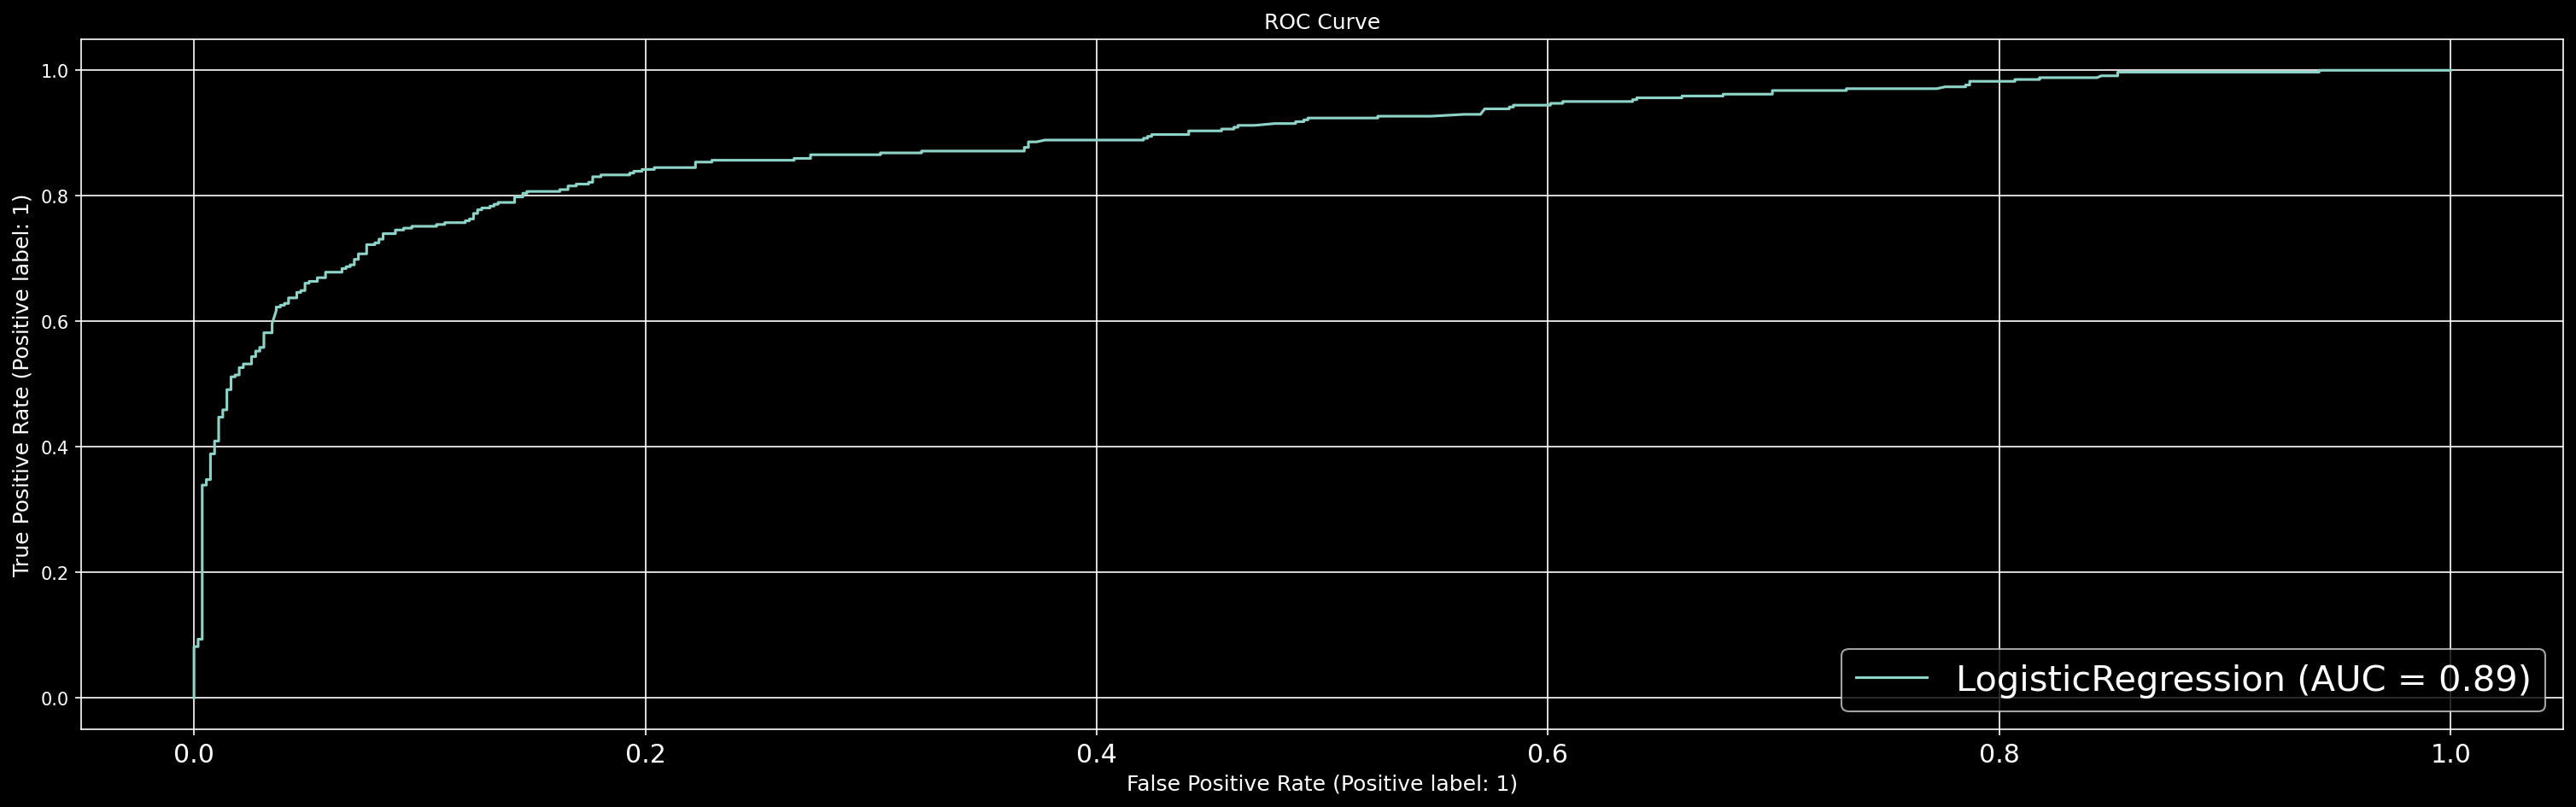

In [195]:
y_pred = model.predict(train)
y_proba = model.predict_proba(train)[:, 1]

print(classification_report(targets, y_pred))

roc_auc = roc_auc_score(targets, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(model, train, targets)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [236]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42, test_size=0.15)


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 15, step=1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10, step=1),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42
    }

    fold_scores = []
    for tr_idx, val_idx in cv.split(train, targets):
        X_tr, X_val = train.iloc[tr_idx], train.iloc[val_idx]
        y_tr, y_val = targets[tr_idx], targets[val_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        fold_scores.append(acc)

    return np.mean(fold_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучший CV-score:", round(study.best_value, 4))
print("Лучшие параметры:", study.best_params)

[I 2025-05-31 14:13:49,169] A new study created in memory with name: no-name-2b02e4a4-9fe6-48bb-a270-7f381b741fa5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 14:13:55,117] Trial 0 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8400000000000001.
[I 2025-05-31 14:14:01,000] Trial 1 finished with value: 0.8244444444444445 and parameters: {'n_estimators': 600, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8400000000000001.
[I 2025-05-31 14:14:15,315] Trial 2 finished with value: 0.8377777777777778 and parameters: {'n_estimators': 1200, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8400000000000001.
[I 2025-05-31 14:14:30,084] Trial 3 finished with value: 0.8344444444444445 and parameters: {'n_estimators': 1100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': Non

In [238]:
params = study.best_params
model = RandomForestClassifier(**params,random_state=42, verbose=True)
model.fit(train, targets)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_leaf=5,
                       min_samples_split=4, n_estimators=800, random_state=42,
                       verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.86      0.91      0.88       549
           1       0.84      0.76      0.80       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891

ROC AUC: 0.9169


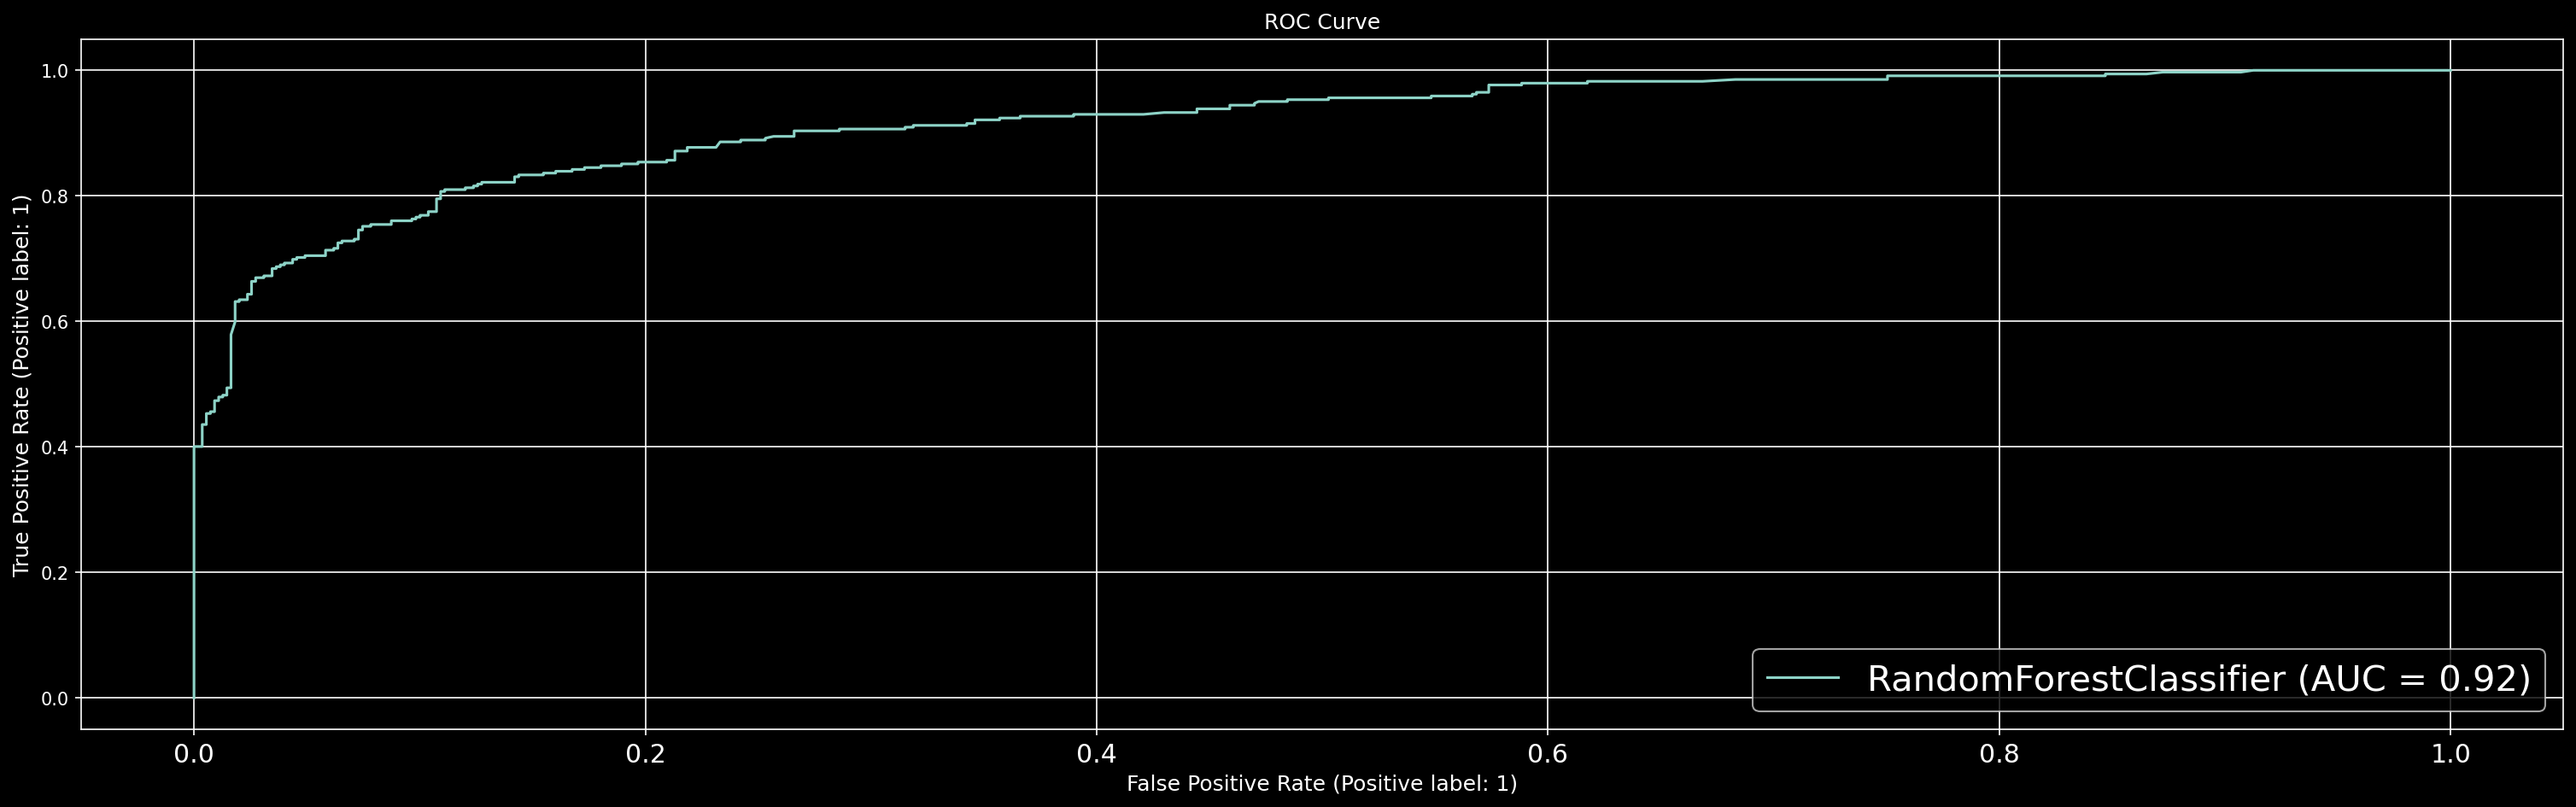

In [239]:
y_pred = model.predict(train)
y_proba = model.predict_proba(train)[:, 1]

print(classification_report(targets, y_pred))

roc_auc = roc_auc_score(targets, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(model, train, targets)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [211]:
import shap

In [212]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values[1], train)

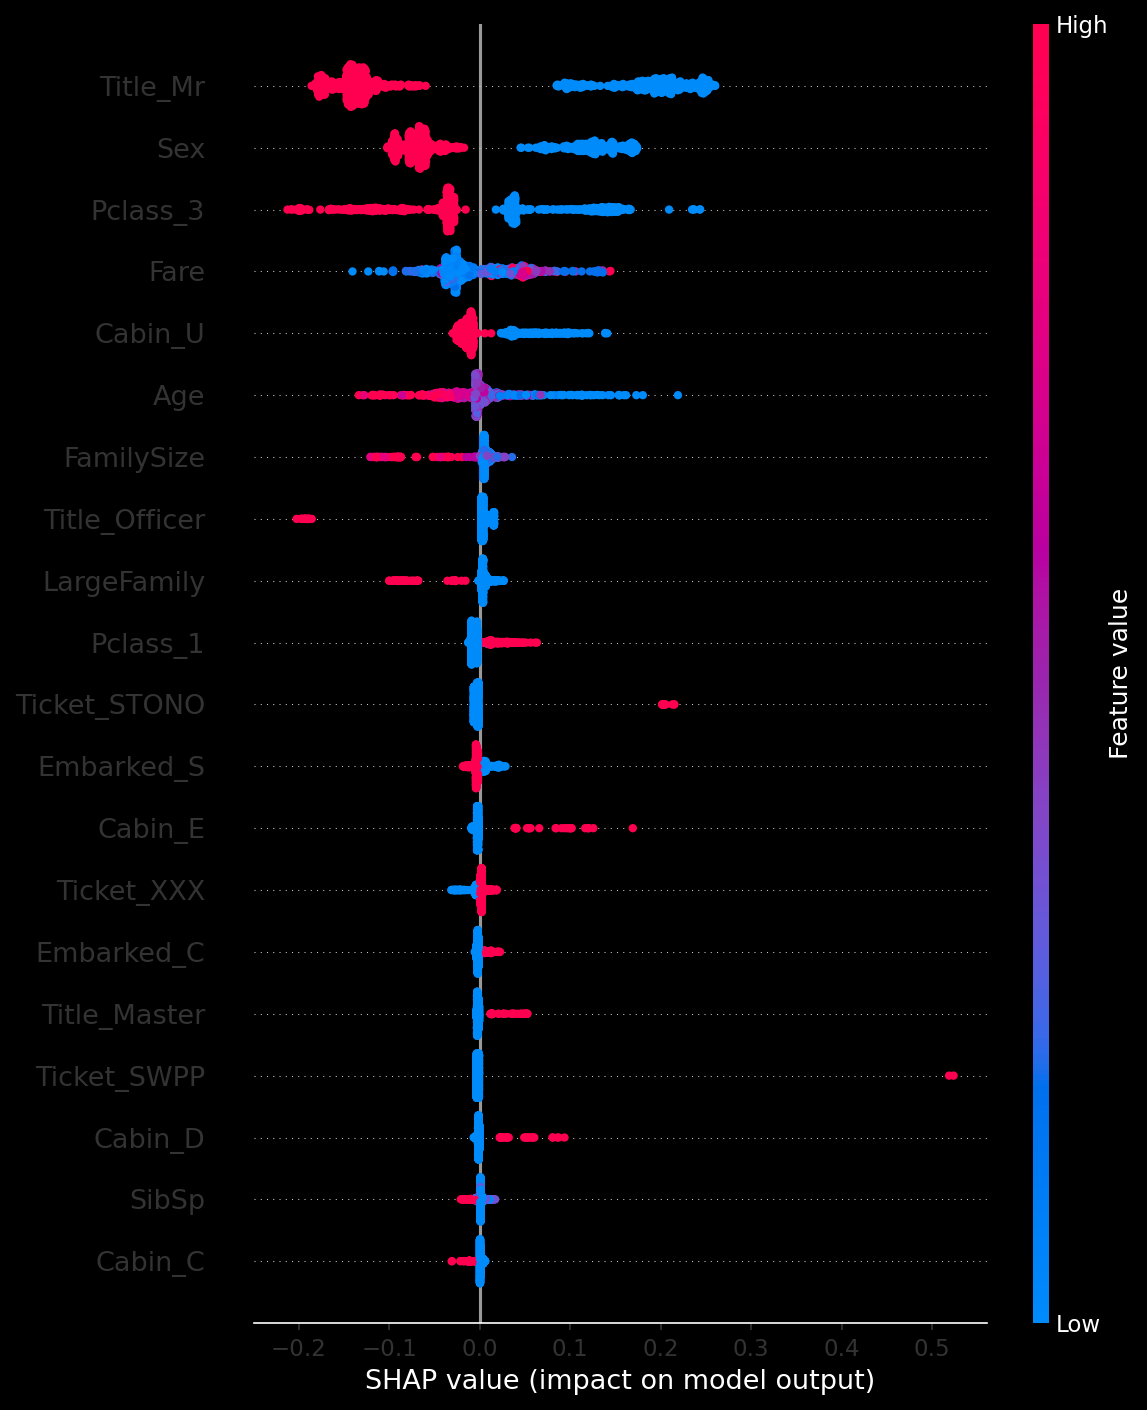

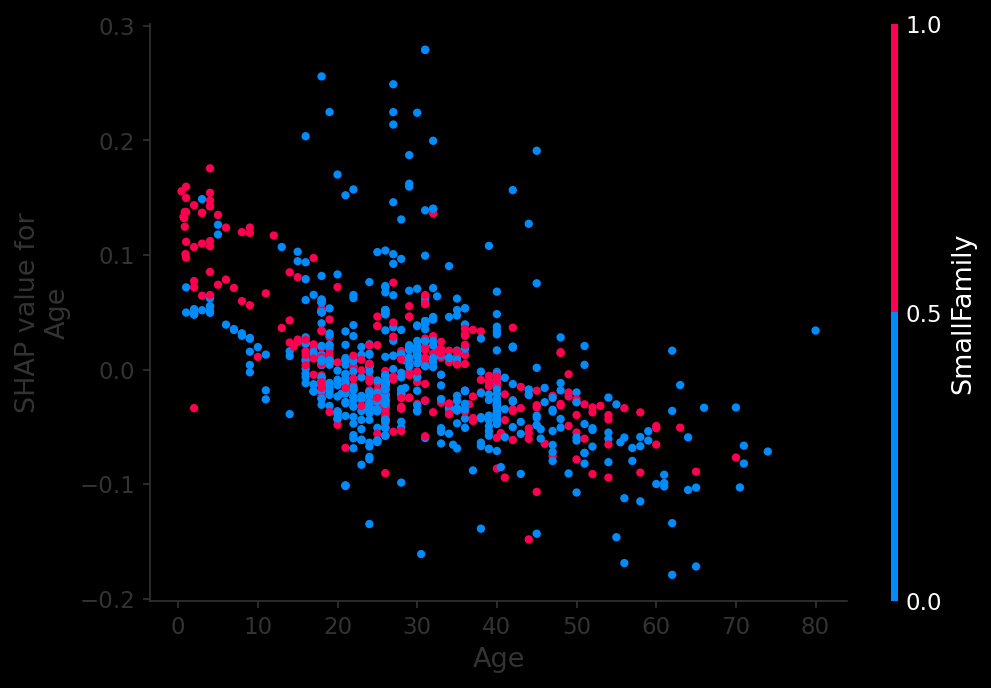

In [235]:
shap.dependence_plot("Age", shap_values[1], train)

In [242]:
for dataset in [train, test]:

    dataset['IsChildAndFirstClass'] = ((dataset['Age'] < 10) & (dataset['Pclass_1'] == 1)).astype(int)
    dataset['IsOLDAndFirstClass'] = ((dataset['Age'] > 50) & (dataset['Pclass_1'] == 1)).astype(int)
    dataset['IsChildAndThirdClass'] = ((dataset['Age'] < 10) & (dataset['Pclass_3'] == 1)).astype(int)
    dataset['MrAndSecondClass'] = ((dataset['Title_Mr'] == 1) & (dataset['Pclass_2'] == 1)).astype(int)
    dataset['MaleAndThirdClass'] = ((dataset['Sex'] == 1) & (dataset['Pclass_3'] == 1)).astype(int)

In [250]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42, test_size=0.15)


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 15, step=1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10, step=1),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42
    }

    fold_scores = []
    for tr_idx, val_idx in cv.split(train, targets):
        X_tr, X_val = train.iloc[tr_idx], train.iloc[val_idx]
        y_tr, y_val = targets[tr_idx], targets[val_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        fold_scores.append(acc)

    return np.mean(fold_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучший CV-score:", round(study.best_value, 4))
print("Лучшие параметры:", study.best_params)

[I 2025-05-31 14:22:10,924] A new study created in memory with name: no-name-7925218f-4cf8-40a9-9aa1-7bd8257ff571


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 14:22:13,734] Trial 0 finished with value: 0.8344444444444445 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8344444444444445.
[I 2025-05-31 14:22:27,490] Trial 1 finished with value: 0.8255555555555556 and parameters: {'n_estimators': 1300, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8344444444444445.
[I 2025-05-31 14:22:34,579] Trial 2 finished with value: 0.8322222222222223 and parameters: {'n_estimators': 1100, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8344444444444445.
[I 2025-05-31 14:22:40,008] Trial 3 finished with value: 0.8211111111111112 and parameters: {'n_estimators': 900, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_feature

In [251]:
model = RandomForestClassifier(random_state=42, verbose=True)
model.fit(train, targets)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(random_state=42, verbose=True)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       549
           1       0.99      0.99      0.99       342

    accuracy                           0.99       891
   macro avg       0.99      0.99      0.99       891
weighted avg       0.99      0.99      0.99       891

ROC AUC: 0.9977


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


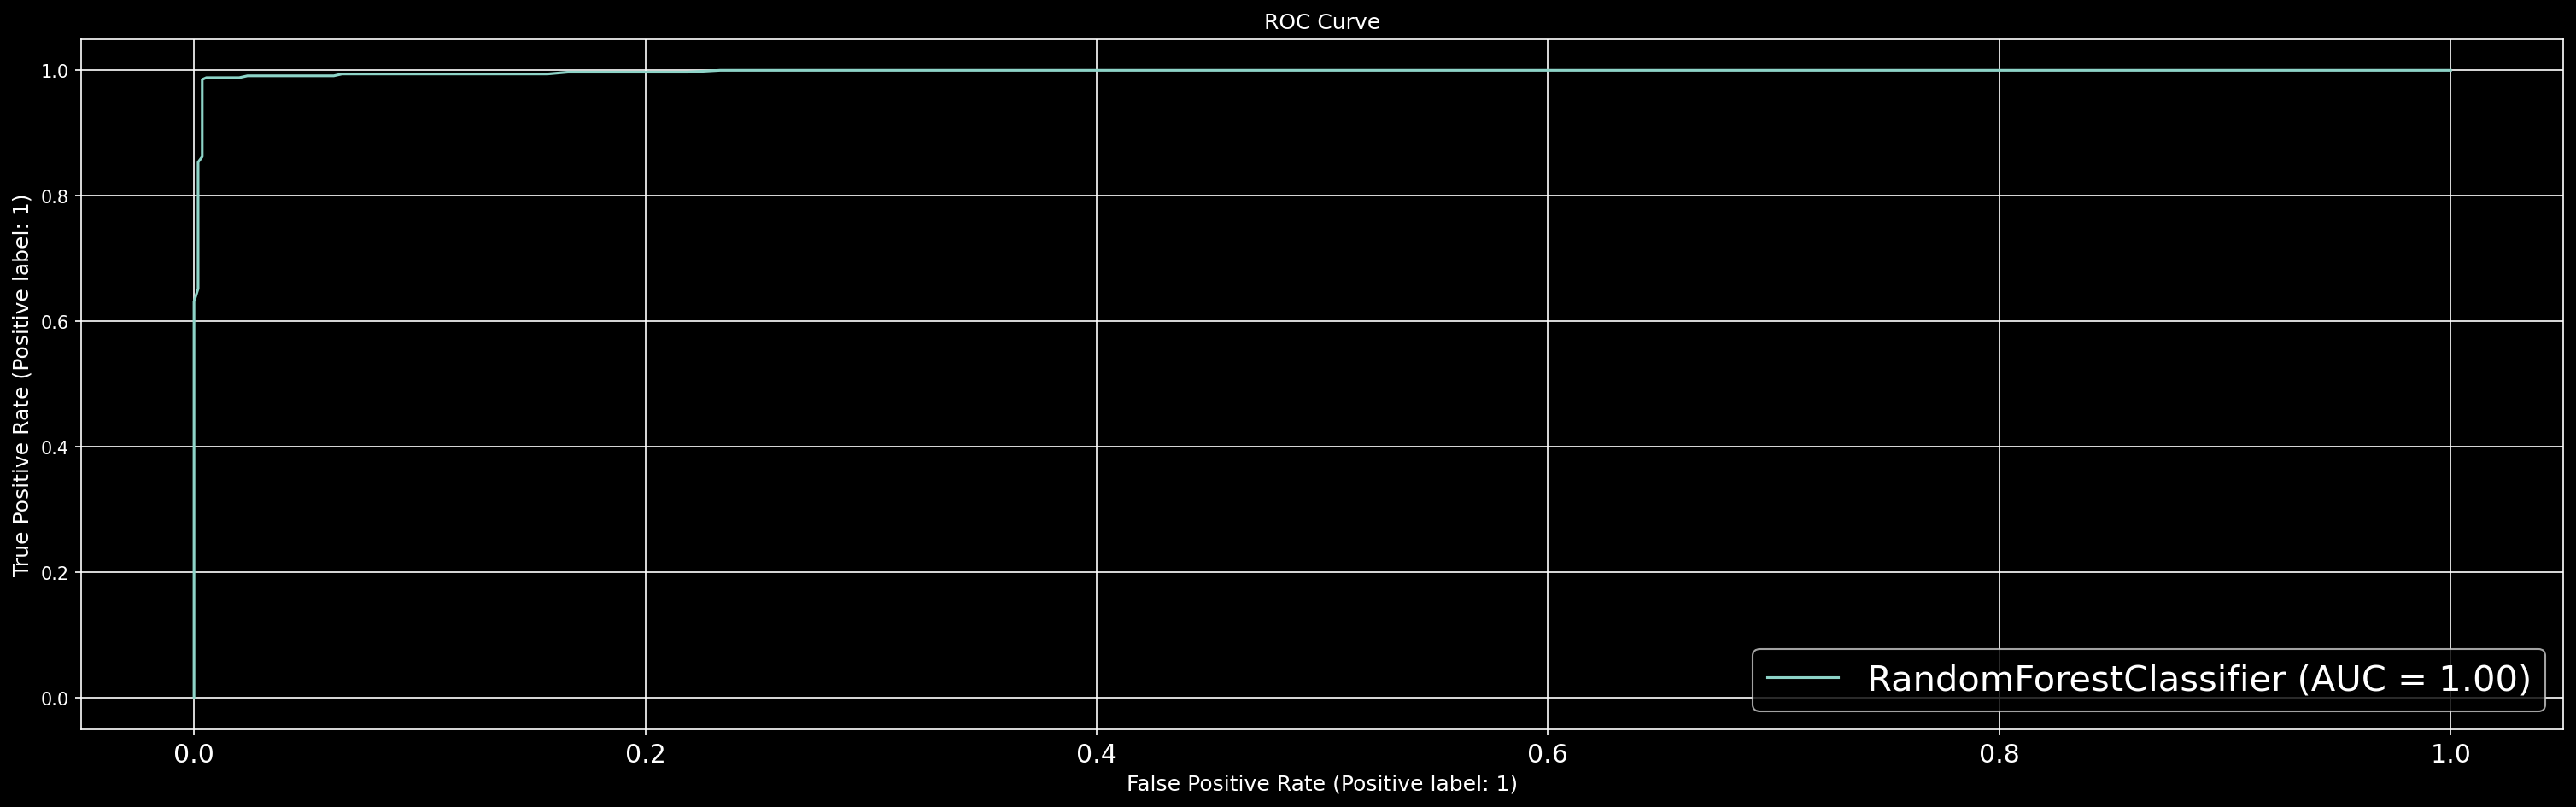

In [252]:
y_pred = model.predict(train)
y_proba = model.predict_proba(train)[:, 1]

print(classification_report(targets, y_pred))

roc_auc = roc_auc_score(targets, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(model, train, targets)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

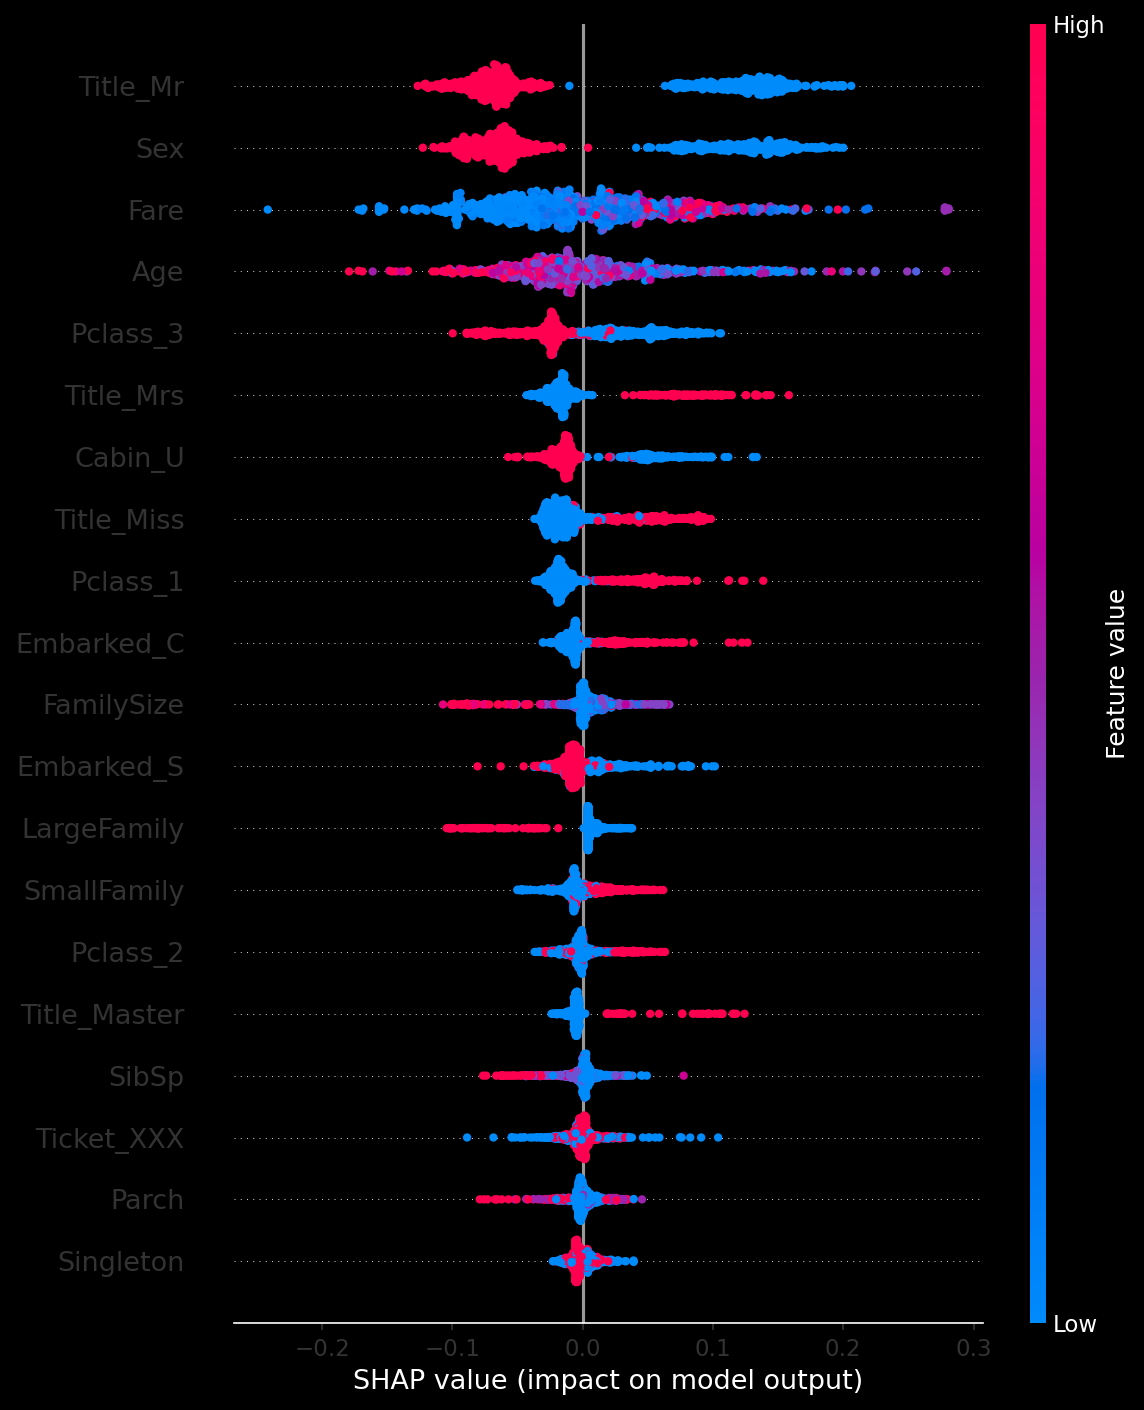

In [233]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values[1], train)

In [253]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('gridsearch_rf.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
